In [6]:
import os
import numpy as np

# Population level
ne = 320
ni = 80
dt = 0.1

# neuron level
tau = 10 # pr(1)
vrev = -80 # pr(2)
refr = 1 # pr(3)
thrs = -50 # pr(4)
mx_noise_dend = 200.0*np.sqrt(dt) # pr(11)
mx_noise_ex_soma = 100.0*np.sqrt(dt) # pr(12)
mx_noise_in_soma = 200.0*np.sqrt(dt) # pr(13)

# synapse level
vrev_ampa = 0 # pr(31)
vrev_gabaA = -70 # pr(32)
vrev_nmda = 0 # pr(33) # unused
vrev_gabaB = -90 # pr(34)
tau_ampa = np.exp(-1*dt/5) # pr(35)
tau_gabaA = np.exp(-1*dt/10) # pr(36)
tau_nmda = np.exp(-1*dt/150) # pr(37)
tau_gabaB = np.exp(-1*dt/150) # pr(38)

nmda_1 = 0.15 # pr(39)
nmda_2 = -0.08 # pr(40)
gabaB_1 = 0.1 # pr(41)
gabaB_2 = 10. # pr(42)

# external ip

fr_ip = dt*1000 / 1000 # pr(71)
g_IE = 1.5 # pr(72)

# Connections
w_EE_ampa = 0.045 # pr(91)
w_EE_nmda = w_EE_ampa*2 #pr(92)
w_EI_ampa = 0.04 # pr(93)
w_EI_nmda = w_EI_ampa # pr(94)
w_IE_gabaA = 0.03 # pr(95)
w_IE_gabaB = w_IE_gabaA*40 # pr(96)
w_IE_gabaB_ON = w_IE_gabaB/3 #pr(97)

# Dend coupling
g_SD = 2 #pr(191)


In [7]:
def input_stim(g_ampa, r):
    temp1 = r.rand(ne+ni)
    sp = np.where(temp1[:int(ne/2)] < fr_ip)
    g_ampa[sp] += g_IE
    return g_ampa


def lif(v_s, v_d, spkt, tr, g_ampa, g_gabaa, g_nmda, g_gabab, r):

    h_nmda = np.zeros((ne+ni))
    h_gabab = np.zeros((ne+ni))
    cond_d = np.zeros((ne+ni))
    cond_s = np.zeros((ne+ni))
    v_infinity = np.zeros((ne+ni))
    tau_eff = np.zeros((ne+ni))
    exp_tau_eff = np.zeros((ne+ni))


    # Reset
    spk = np.zeros((ne+ni), dtype=bool)
    # spki = np.zeros((ne+ni), dtype=int)

    # Excitatory Neurons
    # NMDA
    h_nmda[:ne] = 1/(1+nmda_1*np.exp(nmda_2*v_d[:ne]))
    # GABAB/KIR
    h_gabab[:ne] = 1/(1+np.exp(gabaB_1*(v_d[:ne] - vrev_gabaB + gabaB_2)))
    # Total conductances
    cond_d[:ne] = 1 + g_ampa[:ne] + g_nmda[:ne]*h_nmda[:ne] + g_gabaa[:ne] + (g_gabab[:ne] + w_IE_gabaB_ON)*h_gabab[:ne] + g_SD
    # RANDOM NUMBER
    temp1 = r.rand(ne+ni)
    # u_infinity
    v_infinity[:ne] = vrev + g_gabaa[:ne]*vrev_gabaA + (g_gabab[:ne] + w_IE_gabaB_ON)*h_gabab[:ne]*vrev_gabaB + g_SD*v_s[:ne] + (temp1[:ne]-0.5)*mx_noise_dend
    v_infinity[:ne] = v_infinity[:ne]/cond_d[:ne]
    # tau_effective
    tau_eff[:ne] = tau / cond_d[:ne]
    # new exp soln
    exp_tau_eff[:ne] = np.exp(-1*dt / tau_eff[:ne])
    # update dend memb pot
    v_d[:ne] = v_d[:ne]*exp_tau_eff[:ne] + v_infinity[:ne]*(1-exp_tau_eff[:ne])

    # RANDOM NUMBER
    temp1 = r.rand(ne+ni)
    # not in refrac
    indx = np.where((tr - spkt[:ne]) > refr)
    # tot conductance
    cond_s[indx] = 1 + g_SD
    # u_infinity
    v_infinity[indx] = vrev + g_SD*v_d[indx] + (temp1[indx]-0.5)*mx_noise_ex_soma
    v_infinity[indx] = v_infinity[indx] / cond_s[indx]
    # tau_eff
    tau_eff[indx] = tau / cond_s[indx]
    # new exp for soln
    exp_tau_eff[indx] = np.exp(-1*dt/tau_eff[indx])
    # update memb. pot. at soma
    v_s[indx] = v_s[indx]*exp_tau_eff[indx] + v_infinity[indx]*(1-exp_tau_eff[indx])

    # Inhibitory Neurons
    indx = np.where((tr - spkt[ne:]) > refr)
    indx = tuple([ii+ne for ii in indx])
    #NMDA
    h_nmda[indx] = 1 / (1 + nmda_1*np.exp(nmda_2*v_s[indx]))
    # Total conductances
    cond_s[indx] = 1 + g_ampa[indx] + g_nmda[indx]*h_nmda[indx]
    # u_infinity
    v_infinity[indx] = vrev + (temp1[indx]-0.5)*mx_noise_in_soma
    v_infinity[indx] = v_infinity[indx]/cond_s[indx]
    # tau_eff
    tau_eff[indx] = tau/cond_s[indx]
    #new exp for soln
    exp_tau_eff[indx] = np.exp(-1*dt/tau_eff[indx])
    # update memb. pot. at soma
    v_s[indx] = v_s[indx]*exp_tau_eff[indx] + v_infinity[indx]*(1-exp_tau_eff[indx])

    # Conductance decay
    # ampa
    g_ampa[:] *= tau_ampa
    # gabaA
    g_gabaa[:] *= tau_gabaA
    # nmda
    g_nmda[:] *= tau_nmda
    # gabaB
    g_gabab[:] *= tau_gabaB

    # Spike
    indx = np.where(v_s[:] > thrs)
    spkt[indx] = tr
    spk[indx] = True
    # spki[indx] = 1

    # reset soma pot.
    v_s[indx] = vrev

    # exc. syn spike
    spksum = np.sum(spk[:ne])
    if spksum > 0:
        # ampa ex neurons
        g_ampa[:ne] += (spksum-1)*w_EE_ampa
        # nmda ex neurons
        g_nmda[:ne] += (spksum-1)*w_EE_nmda
        # ampa in neuonrs
        g_ampa[ne:] += spksum*w_EI_ampa
        # nmda in neurons
        g_nmda[ne:] += spksum*w_EI_nmda

    # inh. syn spike
    spksum = np.sum(spk[ne:])
    if spksum > 0:
        # gabaA ex neurons
        g_gabaa[:ne] += spksum*w_IE_gabaA
        # gabaB ex neurons
        g_gabab[:ne] += spksum*w_IE_gabaB

    return v_s, v_d, spkt, spk, g_ampa, g_gabaa, g_nmda, g_gabab

In [8]:
# Create folders
try:
    os.mkdir('data06')
except FileExistsError:
    pass

f1 = open('data06/data01.dat', 'w')
cf1 = csv.writer(f1, delimiter='\t')

f2 = open('data06/data02.dat', 'w')
cf2 = csv.writer(f2, delimiter='\t')

f3 = open('data06/data03.dat', 'w')
cf3 = csv.writer(f3, delimiter='\t')

def write_files(tr, v, v_d, spk):
    for ii in range(ne+ni):
        if spk[ii] > 0:
            cf1.writerow([tr, ii])
    if spk[0]:
        cf2.writerow([tr, v_d[0], 10])
    else:
        cf2.writerow([tr, v_d[0], v_s[0]])
    if spk[199]:
        cf3.writerow([tr, v_d[199], 10])
    else:
        cf3.writerow([tr, v_d[199], v_s[199]])

# seed
seed = 13
r = np.random.RandomState(seed)

# Allocate - equivalent
v_s = np.zeros((ne+ni))
v_d = np.zeros((ne+ni))
g_ampa = np.zeros((ne+ni))
g_gabaa = np.zeros((ne+ni))
g_nmda = np.zeros((ne+ni))
g_gabab = np.zeros((ne+ni))
spkt = np.zeros((ne+ni))

# Initialize - equivalent
temp1 = r.rand(ne+ni)
v_s[:] = vrev_gabaA + ((2.*temp1) - 1)*10.
temp1 = r.rand(ne+ni)
v_d[:] = vrev_gabaA + ((2.*temp1) - 1)*10.

tr = 0
# Without external inputs
for t in range(1000):
    tr += dt
    v_s, v_d, spkt, spk, g_ampa, g_gabaa, g_nmda, g_gabab = lif(v_s, v_d, spkt, tr, g_ampa, g_gabaa, g_nmda, g_gabab, r)
    write_files(tr, v_s, v_d, spk)
    
# input activating half of exc. neurons
for t in range(1000):
    tr += dt
    g_ampa = input_stim(g_ampa, r)
    v_s, v_d, spkt, spk, g_ampa, g_gabaa, g_nmda, g_gabab = lif(v_s, v_d, spkt, tr, g_ampa, g_gabaa, g_nmda, g_gabab, r)
    write_files(tr, v_s, v_d, spk)
    
for t in range(1000):
    tr += dt
    v_s, v_d, spkt, spk, g_ampa, g_gabaa, g_nmda, g_gabab = lif(v_s, v_d, spkt, tr, g_ampa, g_gabaa, g_nmda, g_gabab, r)
    write_files(tr, v_s, v_d, spk)
    
f1.close()
f2.close()
f3.close()

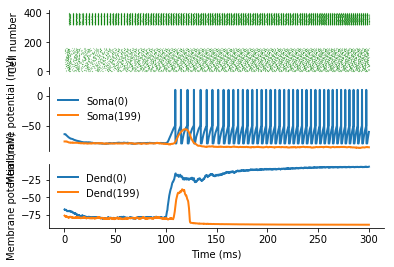

In [9]:
import os
import csv
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

def raster_plot(ax):
    data = np.loadtxt('data06/data01.dat', delimiter='\t')
    ax.plot(data[:,0], data[:,1], 'go', markersize=0.1)
    ax.set_ylabel('Cell number')
    ax.get_xaxis().set_visible(False)
    ax.spines['bottom'].set_visible(False)
    return ax

def pot_cell(ax1, ax2):
    data1 = np.loadtxt('data06/data02.dat', delimiter='\t')
    data2 = np.loadtxt('data06/data03.dat', delimiter='\t')
  
    ax1.plot(data1[:,0], data1[:,2], lw=2, label='Soma(0)')
    ax1.plot(data2[:,0], data2[:,2], lw=2, label='Soma(199)')
    
    ax2.plot(data1[:,0], data1[:,1], lw=2, label='Dend(0)')
    ax2.plot(data2[:,0], data2[:,1], lw=2, label='Dend(199)')
    ax1.legend(frameon=False, loc=2)
    ax2.legend(frameon=False, loc=2)
    ax1.get_xaxis().set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_ylabel('Membrane potential (mV)')
    ax2.set_ylabel('Membrane potential (mV)')
    ax2.set_xlabel('Time (ms)')    
    return ax1, ax2

def clean_ax(axs):
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)  

        
gs = gridspec.GridSpec(3, 1)
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[2, 0])
ax0 = raster_plot(ax0)
ax1, ax2 = pot_cell(ax1, ax2)
clean_ax([ax0, ax1, ax2])
plt.show()